In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import json

plt.style.use('default')
sns.set_palette("husl")

In [16]:
# Define path to the data
data_dir = Path("data")
train_images_dir = data_dir / "Training-labeled" / "images"
train_labels_dir = data_dir / "Training-labeled" / "labels"
tuning_images_dir = data_dir / "Tuning" / "images"
tuning_labels_dir = data_dir / "Tuning" / "labels"

print(f"Training images: {train_images_dir}")
print(f"Training labels: {train_labels_dir}")
print(f"Tuning images: {tuning_images_dir}")
print(f"Tuning labels: {tuning_labels_dir}")

Training images: data/Training-labeled/images
Training labels: data/Training-labeled/labels
Tuning images: data/Tuning/images
Tuning labels: data/Tuning/labels


In [17]:
# Get all image and label files with different formats
train_images = []
for ext in ['*.bmp', '*.tif', '*.tiff', '*.png', '*.jpg', '*.jpeg']:
    train_images.extend(train_images_dir.glob(ext))
train_images = sorted(train_images)

train_labels = []
for ext in ['*.tif', '*.tiff', '*.png']:
    train_labels.extend(train_labels_dir.glob(ext))
train_labels = sorted(train_labels)

tuning_images = []
for ext in ['*.bmp', '*.tif', '*.tiff', '*.png', '*.jpg', '*.jpeg']:
    tuning_images.extend(tuning_images_dir.glob(ext))
tuning_images = sorted(tuning_images)

tuning_labels = []
for ext in ['*.tif', '*.tiff', '*.png']:
    tuning_labels.extend(tuning_labels_dir.glob(ext))
tuning_labels = sorted(tuning_labels)

print(f"Training images: {len(train_images)}")
print(f"Training labels: {len(train_labels)}")
print(f"Tuning images: {len(tuning_images)}")
print(f"Tuning labels: {len(tuning_labels)}")

# Show file format distribution
print("\nTraining image formats:")
train_formats = [img.suffix.lower() for img in train_images]
format_counts = pd.Series(train_formats).value_counts()
print(format_counts)

print("\nTraining label formats:")
label_formats = [label.suffix.lower() for label in train_labels]
label_format_counts = pd.Series(label_formats).value_counts()
print(label_format_counts)

# Show first few filenames with their formats
print("\nFirst 10 training images:")
for img in train_images[:10]:
    print(f"  {img.name} ({img.suffix})")

Training images: 1000
Training labels: 1000
Tuning images: 101
Tuning labels: 101

Training image formats:
.tif     447
.png     370
.bmp     139
.tiff     44
Name: count, dtype: int64

Training label formats:
.tiff    1000
Name: count, dtype: int64

First 10 training images:
  cell_00001.bmp (.bmp)
  cell_00002.bmp (.bmp)
  cell_00003.bmp (.bmp)
  cell_00004.bmp (.bmp)
  cell_00005.bmp (.bmp)
  cell_00006.bmp (.bmp)
  cell_00007.bmp (.bmp)
  cell_00008.bmp (.bmp)
  cell_00009.bmp (.bmp)
  cell_00010.bmp (.bmp)


Sample image: cell_00001.bmp (.bmp)
Sample label: cell_00001_label.tiff (.tiff)
Image shape: (1920, 2560, 3)
Image dtype: uint8
Image min/max values: 21/216
Image channels: 3
RGB image
Label shape: (1920, 2560)
Label dtype: uint16
Label unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11]


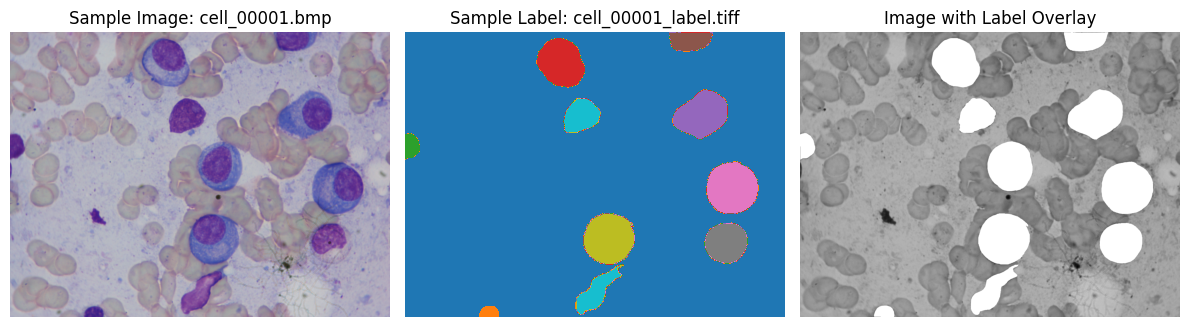

In [18]:
# Load a sample image (handles different formats)
sample_img_path = train_images[0]
sample_label_path = train_labels[0]

print(f"Sample image: {sample_img_path.name} ({sample_img_path.suffix})")
print(f"Sample label: {sample_label_path.name} ({sample_label_path.suffix})")

# Load image with PIL (handles all formats)
img_pil = Image.open(sample_img_path)
img_array = np.array(img_pil)

print(f"Image shape: {img_array.shape}")
print(f"Image dtype: {img_array.dtype}")
print(f"Image min/max values: {img_array.min()}/{img_array.max()}")

# Handle different image modes
if len(img_array.shape) == 3:
    print(f"Image channels: {img_array.shape[2]}")
    if img_array.shape[2] == 3:
        print("RGB image")
    elif img_array.shape[2] == 4:
        print("RGBA image")
else:
    print("Grayscale image")

# Display the image
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
if len(img_array.shape) == 3:
    plt.imshow(img_array)
else:
    plt.imshow(img_array, cmap='gray')
plt.title(f"Sample Image: {sample_img_path.name}")
plt.axis('off')

# Load and display label
label_pil = Image.open(sample_label_path)
label_array = np.array(label_pil)

print(f"Label shape: {label_array.shape}")
print(f"Label dtype: {label_array.dtype}")
print(f"Label unique values: {np.unique(label_array)}")

plt.subplot(1, 3, 2)
plt.imshow(label_array, cmap='tab10')
plt.title(f"Sample Label: {sample_label_path.name}")
plt.axis('off')

# Show overlay
plt.subplot(1, 3, 3)
if len(img_array.shape) == 3:
    # Convert RGB to grayscale for overlay
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
else:
    img_gray = img_array

# Create overlay
overlay = img_gray.copy()
if label_array.max() > 0:
    overlay[label_array > 0] = 255

plt.imshow(overlay, cmap='gray')
plt.title("Image with Label Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Analyze format distribution and file sizes
format_analysis = []
for img_path in train_images[:50]:  # Analyze first 50 for speed
    try:
        img = Image.open(img_path)
        img_array = np.array(img)
        
        info = {
            'filename': img_path.name,
            'format': img_path.suffix.lower(),
            'shape': img_array.shape,
            'dtype': str(img_array.dtype),
            'file_size_mb': img_path.stat().st_size / (1024 * 1024),
            'min_val': img_array.min(),
            'max_val': img_array.max(),
            'mean_val': img_array.mean(),
            'std_val': img_array.std()
        }
        format_analysis.append(info)
    except Exception as e:
        print(f"Error loading {img_path.name}: {e}")

df_format_analysis = pd.DataFrame(format_analysis)
print("Format Analysis Summary:")
print(df_format_analysis.groupby('format').agg({
    'file_size_mb': ['count', 'mean', 'std'],
    'mean_val': ['mean', 'std'],
    'max_val': 'max'
}).round(2))

Format Analysis Summary:
       file_size_mb             mean_val       max_val
              count  mean   std     mean   std     max
format                                                
.bmp             48  9.60  1.70   167.04  7.66     255
.png              2  2.19  0.06   116.49  9.89     255
